In [ ]:
! wget https://data.hydrosheds.org/file/hydrosheds-v1-con/au_con_3s/s40e170_con.zip

In [2]:
! unzip -o s40e170_con.zip

Archive:  s40e170_con.zip
 extracting: s40e170_con.tif         
 extracting: HydroSHEDS_TechDoc_v1_4.pdf  


In [3]:
! gdalinfo s40e170_con.tif

Driver: GTiff/GeoTIFF
Files: s40e170_con.tif
Size is 12000, 12000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (170.000000000000000,-30.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
  DataType=Generic
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 170.0000000, -30.0000000) (170d 0' 0.00"E, 30d 0' 0.00"S)
Lower Left  ( 170.0000000, -40.0000000) (170d 0' 0.00"E, 40d 0' 0.00"S)
Upper Right ( 180.0000

In [8]:
%%bash 

export PROJ_LIB=/home/docker/miniconda3/share/proj
rm -rf s40e170_con_merc.tif
gdalwarp -s_srs epsg:4326 -t_srs epsg:3857 s40e170_con.tif s40e170_con_merc.tif

Creating output file that is 10738P x 13142L.
Processing s40e170_con.tif [1/1] : 0Using internal nodata values (e.g. 32767) for image s40e170_con.tif.
Copying nodata values from source s40e170_con.tif to destination s40e170_con_merc.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [9]:
import rasterio
import matplotlib.pyplot as plt
import copy
from base64 import b64encode
import numpy as np
import ipyleaflet

cmap = copy.copy(plt.get_cmap('jet'))
cmap.set_under('k', alpha=0)

def geotiff_to_png(filein, fileout, cmap='jet', vmin=0.1, vmax=2000, mask_value=32767):

    print(f'Reading {filein}')
    src = rasterio.open(filein)
    print(src.crs.to_proj4())
    print(src.bounds)
    
    data = src.read(1)
    print(data.shape, data.min(), data.max())
    data = np.where(data == mask_value, np.nan, data)
    print(data.shape, np.nanmin(data), np.nanmax(data))

    print(f'Plotting into {fileout}')
    plt.imshow(data, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.savefig(fileout, transparent=True, bbox_inches='tight', dpi=500,pad_inches = 0)
    plt.show()
    plt.close()

def get_latlon_gridlines(window=[-180,180,-90,90], dx=10,dy=10):
    x1,x2,y1,y2 = window
    gridlines = []
    # parallels for each lat
    for lat in np.arange(y1, y2+dy/2, dy):
        gridlines += [([lat,x1], [lat,x2])]
    # meridians for each lon    
    for lon in  np.arange(x1, x2+dx/2, dx):
        gridlines += [([y1,lon], [y2,lon])]

    return(gridlines)

Reading s40e170_con_merc.tif
+init=epsg:3857
BoundingBox(left=18924313.434856508, bottom=-4865990.889283198, right=20037426.317867253, top=-3503549.8435043744)
(13142, 10738) -51 32767
(13142, 10738) -51.0 2720.0
Plotting into pngs/s40e170_con_merc.png


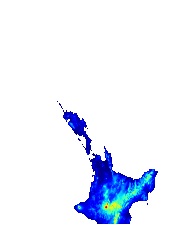

In [11]:
geotiff_to_png('s40e170_con_merc.tif', 'pngs/s40e170_con_merc.png', cmap='jet')

In [16]:
! gdalinfo s40e170_con.tif

Driver: GTiff/GeoTIFF
Files: s40e170_con.tif
Size is 12000, 12000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (170.000000000000000,-30.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
  DataType=Generic
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 170.0000000, -30.0000000) (170d 0' 0.00"E, 30d 0' 0.00"S)
Lower Left  ( 170.0000000, -40.0000000) (170d 0' 0.00"E, 40d 0' 0.00"S)
Upper Right ( 180.0000

In [17]:
# bounds = ((miny, minx), (maxy, maxx))
x1,x2,y1,y2 = 170,180,-40,-30
bounds = ((y1, x1), (y2,x2))
print(bounds)

gridlines = get_latlon_gridlines(window=[x1,x2,y1,y2], dx=1,dy=1)


((-40, 170), (-30, 180))


In [20]:

m = ipyleaflet.Map(center=[-40,170], zoom = 4, scroll_wheel_zoom=True)


m.add_layer(
    ipyleaflet.Polyline(
        name='gridlines',
        locations=gridlines, 
        color="gray" , 
        fill=False, 
        weight=1
    )
)

with open('pngs/s40e170_con_merc.png', "rb") as f:
    data = b64encode(f.read())
    data = data.decode("ascii")
    imgurl = "data:image/png;base64," + data

image = ipyleaflet.ImageOverlay(url=imgurl, bounds=bounds, opacity=0.4, name='merc')
m.add_layer(image)

m.add_control(ipyleaflet.LayersControl())
m


Map(center=[-40, 170], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…